## Inisialisasi 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format ='retina'
plt.style.use ('default')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Memuat Data

*Dataset* yang Anda perlukan disimpan di folder `/datasets/faces/`. Pada folder tersebut, Anda bisa menemukan: - Folder `final_file` dengan 7,6 ribu foto 
- *File* `labels.csv` yang memuat label, dengan dua kolom: `file_name` dan `real_age` 

Mengingat jumlah *file* gambar cukup banyak, Anda disarankan untuk tidak membacanya sekaligus, karena hal ini hanya akan menghabiskan sumber daya komputasi. Kami sarankan Anda untuk membuat generator dengan ImageDataGenerator. Metode ini telah dijelaskan sebelumnya di Bab 3, Pelajaran ke-7. 

*File* label bisa dimuat sebagai *file* CSV biasa.

In [2]:
#memuat dataset
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
#cek dataset
labels.head()

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

In [4]:
#cek dataset info
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
#cek deskripsi dataset
labels.describe(percentiles=( .1, .05, .25, .75, .95, .99)).round(1)

real_age
count    7591.0
mean       31.2
std        17.1
min         1.0
5%          5.0
10%        12.0
25%        20.0
50%        29.0
75%        41.0
95%        63.0
99%        82.0
max       100.0

In [6]:
#cek missing value
labels.isnull().sum().sort_values(ascending = False)

file_name    0
real_age     0
dtype: int64

Findings :
- dataset gambar berisi foto dengan label berjumlah 7591
- tidak ada data yang hilang
- rata-rata umur dari foto yang ada di dataset adalah 29 tahun

## EDA

In [7]:
#membuat fungsi untuk membaca file gambar untuk umur 0-100 tahun
def create_gen_flow(min_age=0, max_age=100):
    
    train_datagen = ImageDataGenerator(rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels.query('real_age >= @min_age and real_age <= @max_age'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return train_gen_flow

In [8]:
#count of distinct age values with 0 for missing ages
df = labels['real_age'].value_counts().sort_index().reindex(np.arange(0,101)).fillna(0).astype('int')
df

0        0
1      149
2       88
3       25
4      101
      ... 
96       2
97       1
98       0
99       0
100      1
Name: real_age, Length: 101, dtype: int64

In [9]:
#dikelompokkan berdasarkan umur dengan range 10 tahunan
df2 = pd.cut(labels['real_age'],np.arange(0, 101, 10), right=False).value_counts().sort_index()
df2

[0, 10)       663
[10, 20)     1213
[20, 30)     2075
[30, 40)     1564
[40, 50)      940
[50, 60)      615
[60, 70)      279
[70, 80)      130
[80, 90)       78
[90, 100)      33
Name: real_age, dtype: int64

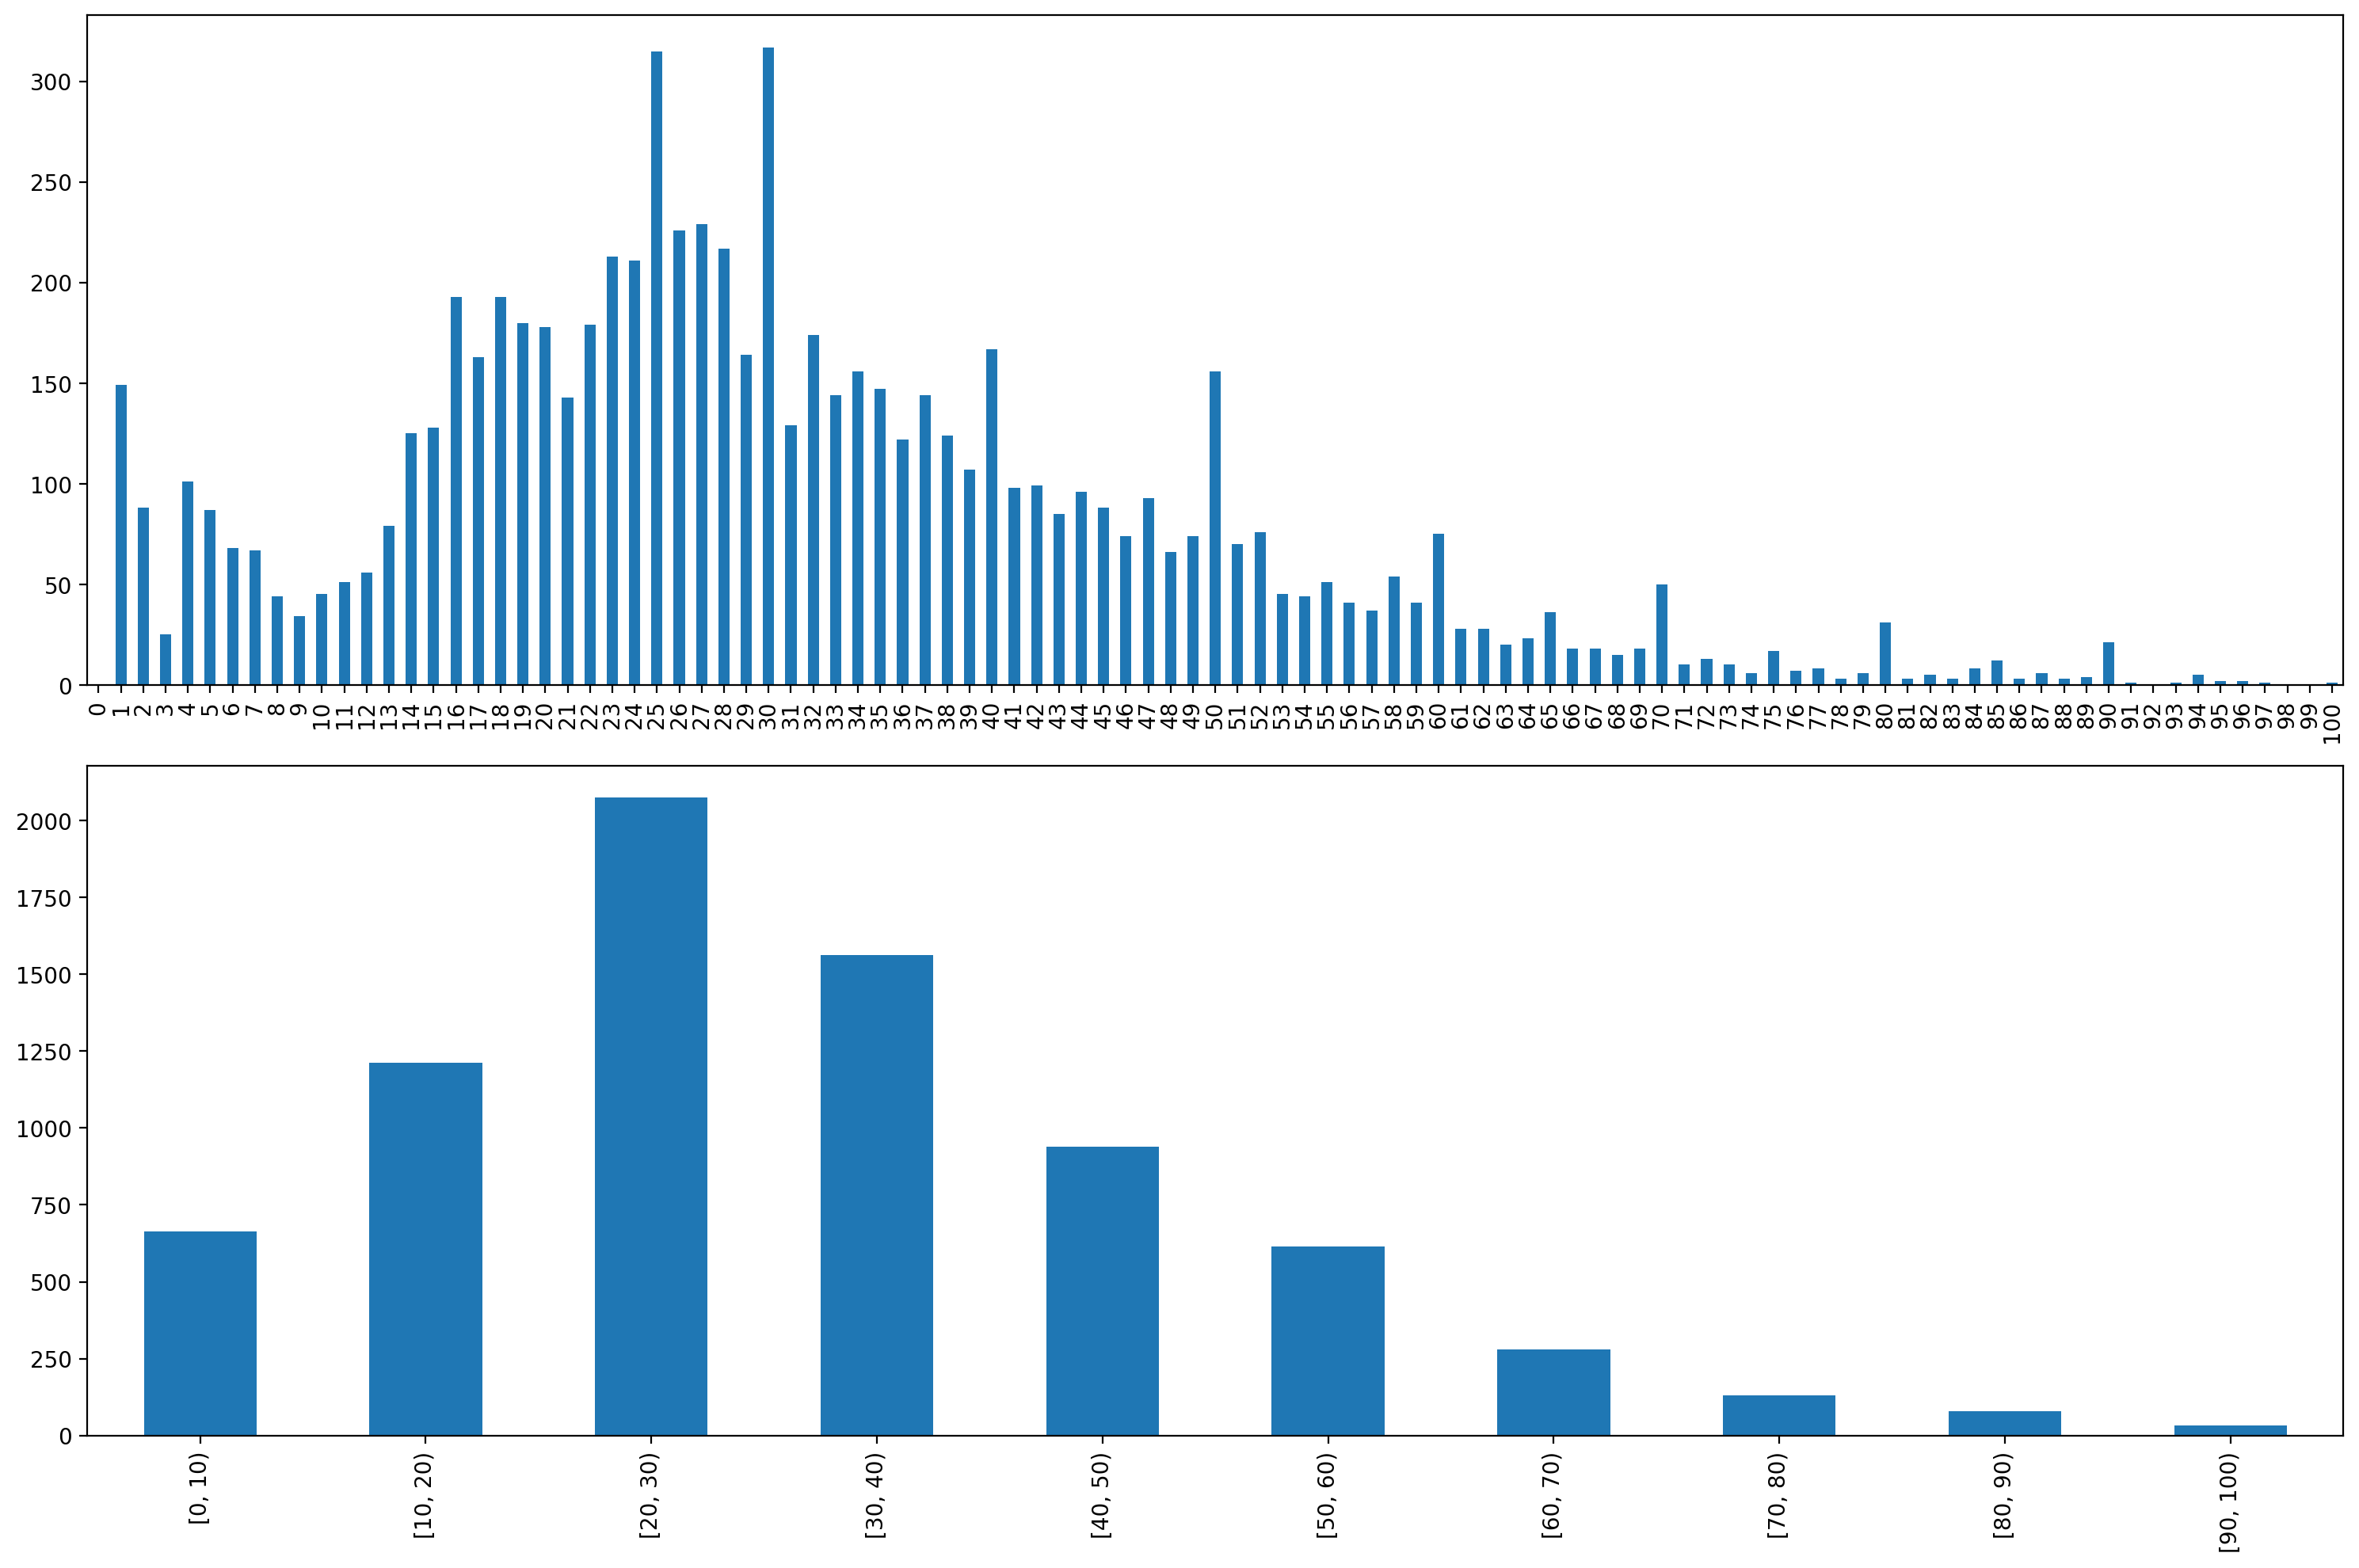

In [10]:
#tamppilan distribusi dataset berdasarkan umur
fig, axs = plt.subplots(2,1, figsize=(15,10))

ax = axs[0]
df.plot(kind='bar', ax=ax)

ax = axs[1]
df2.plot(kind='bar', ax=ax)

fig.tight_layout()

Findings:
- ukuran dataset di dominasi oleh kelompok umur 15-40 tahun
- jumlah kelompok umur tua ( diatas 60 tahun ) hanya sedikit, kemungkinan model akan tidak akan ter-training dengan baik di kelompok umur ini sehingga kemungkinan kesalahanyang terjadi makin besar
- ada beberapa umur yang jumlah sample nya tinggi, ada kemungkinan ini outlier karena umur sebenarnya tidak di ketahui dari beberapa contoh foto dalam dataset sehingga angkanya adalah hasil perkiraan
- untuk analisa selanjutnya bisa berdasarkan beberapa kelompok umur, misalnya anak-anak, dewasa, dan tua

In [11]:
#buat fungsi untuk menampilan foto sesuai group umur
def show_batch (batch, predictions=None):
    
    rows = 3
    cols = 5
    fig, axs = plt.subplots(rows, cols, figsize=(10,6))
    for i in range (15):
        row = i // cols
        col = i % cols
        ax = axs[row][col]
        ax.imshow(batch[0][i])
        real_age = batch[1][i]
        if predictions is None:
            title = f'age :  {real_age}'  
        else:
            title = f'age : {real_age}, pred: {round(predictions[i])}'
           
        ax.set_title(title, fontsize='medium')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    fig.tight_layout()
        

In [12]:
gen_0_10 = create_gen_flow(min_age = 0, max_age = 10)
gen_30_40 = create_gen_flow(min_age = 30, max_age = 40)
gen_90_100 = create_gen_flow(min_age = 90, max_age = 100)

Found 708 validated image filenames.
Found 1731 validated image filenames.
Found 34 validated image filenames.


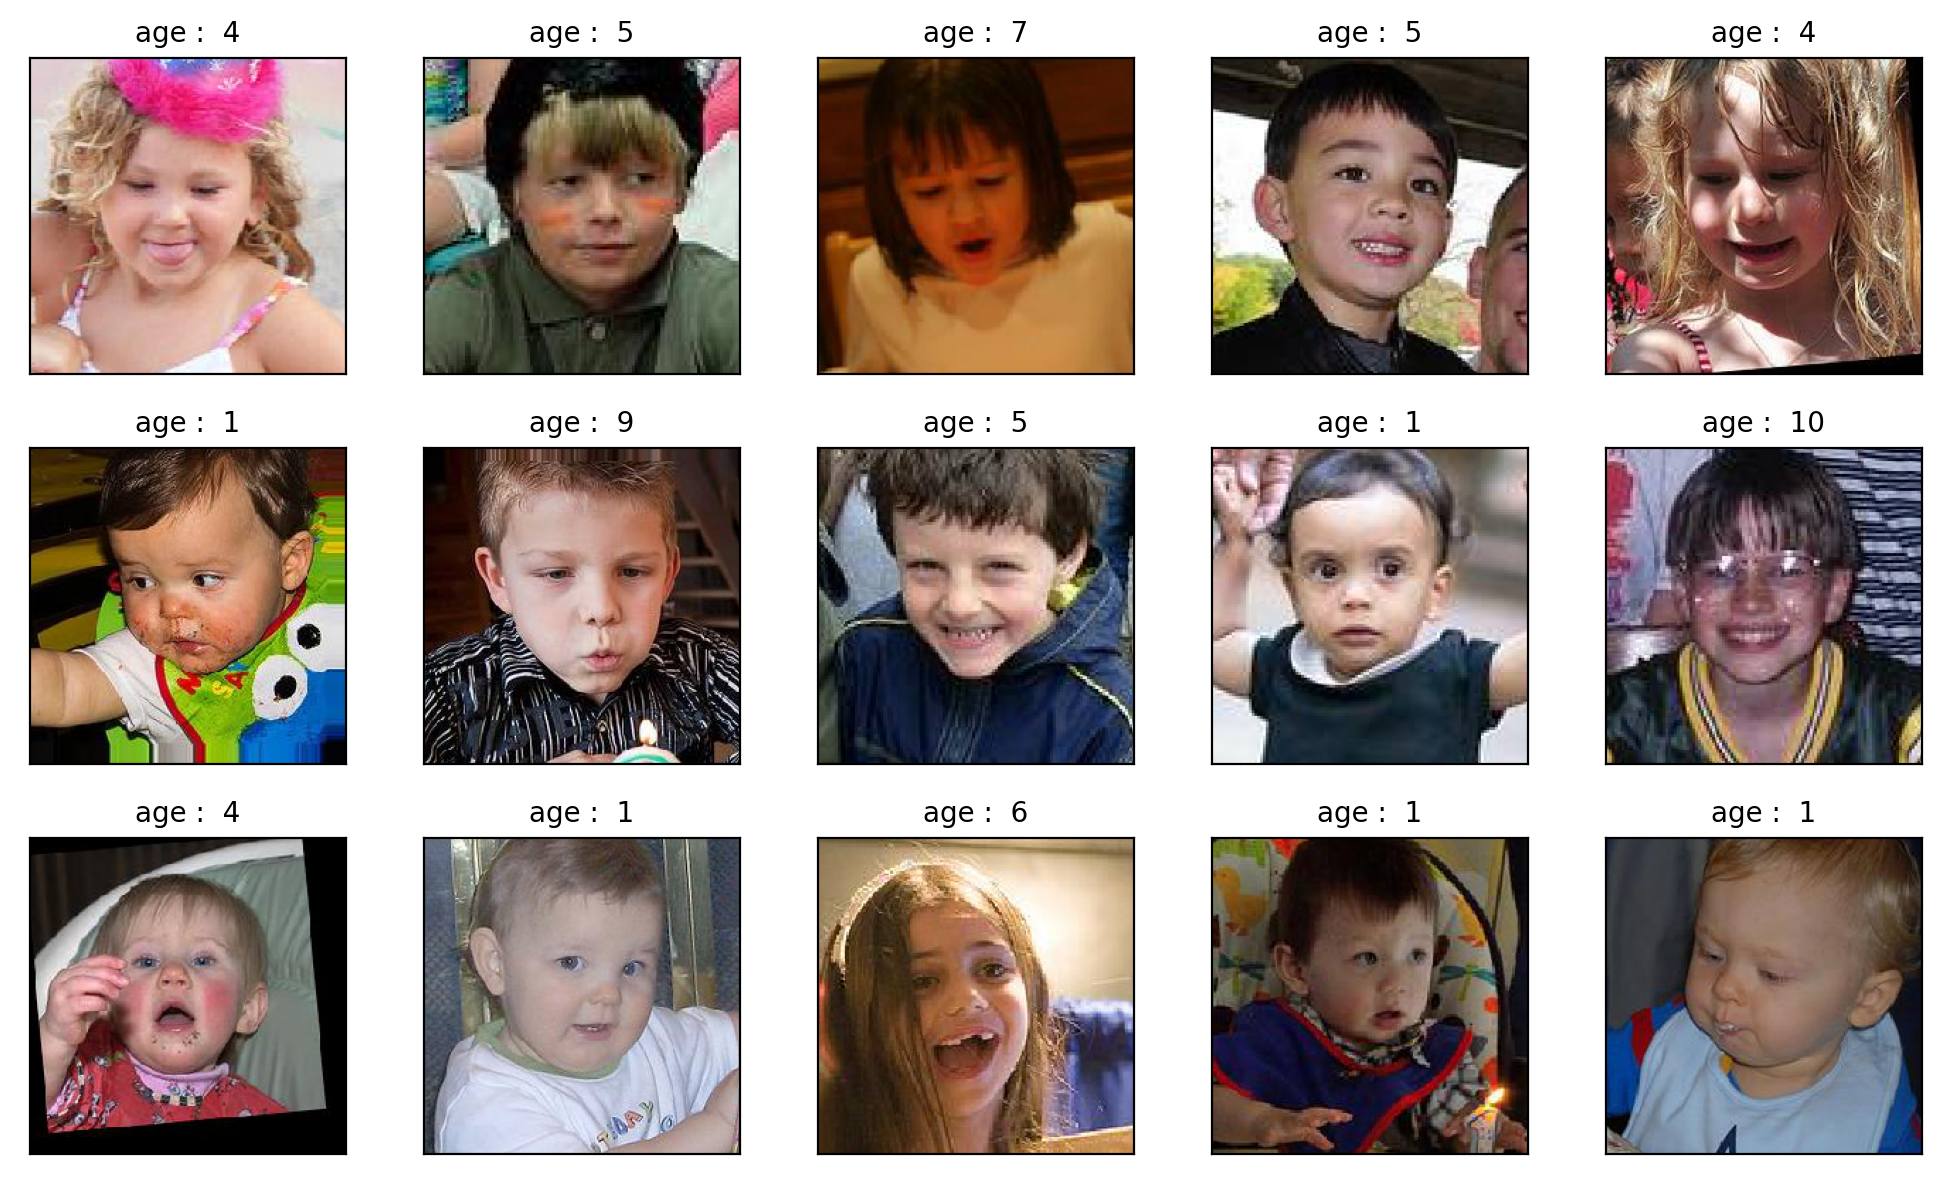

In [13]:
show_batch(next(gen_0_10))

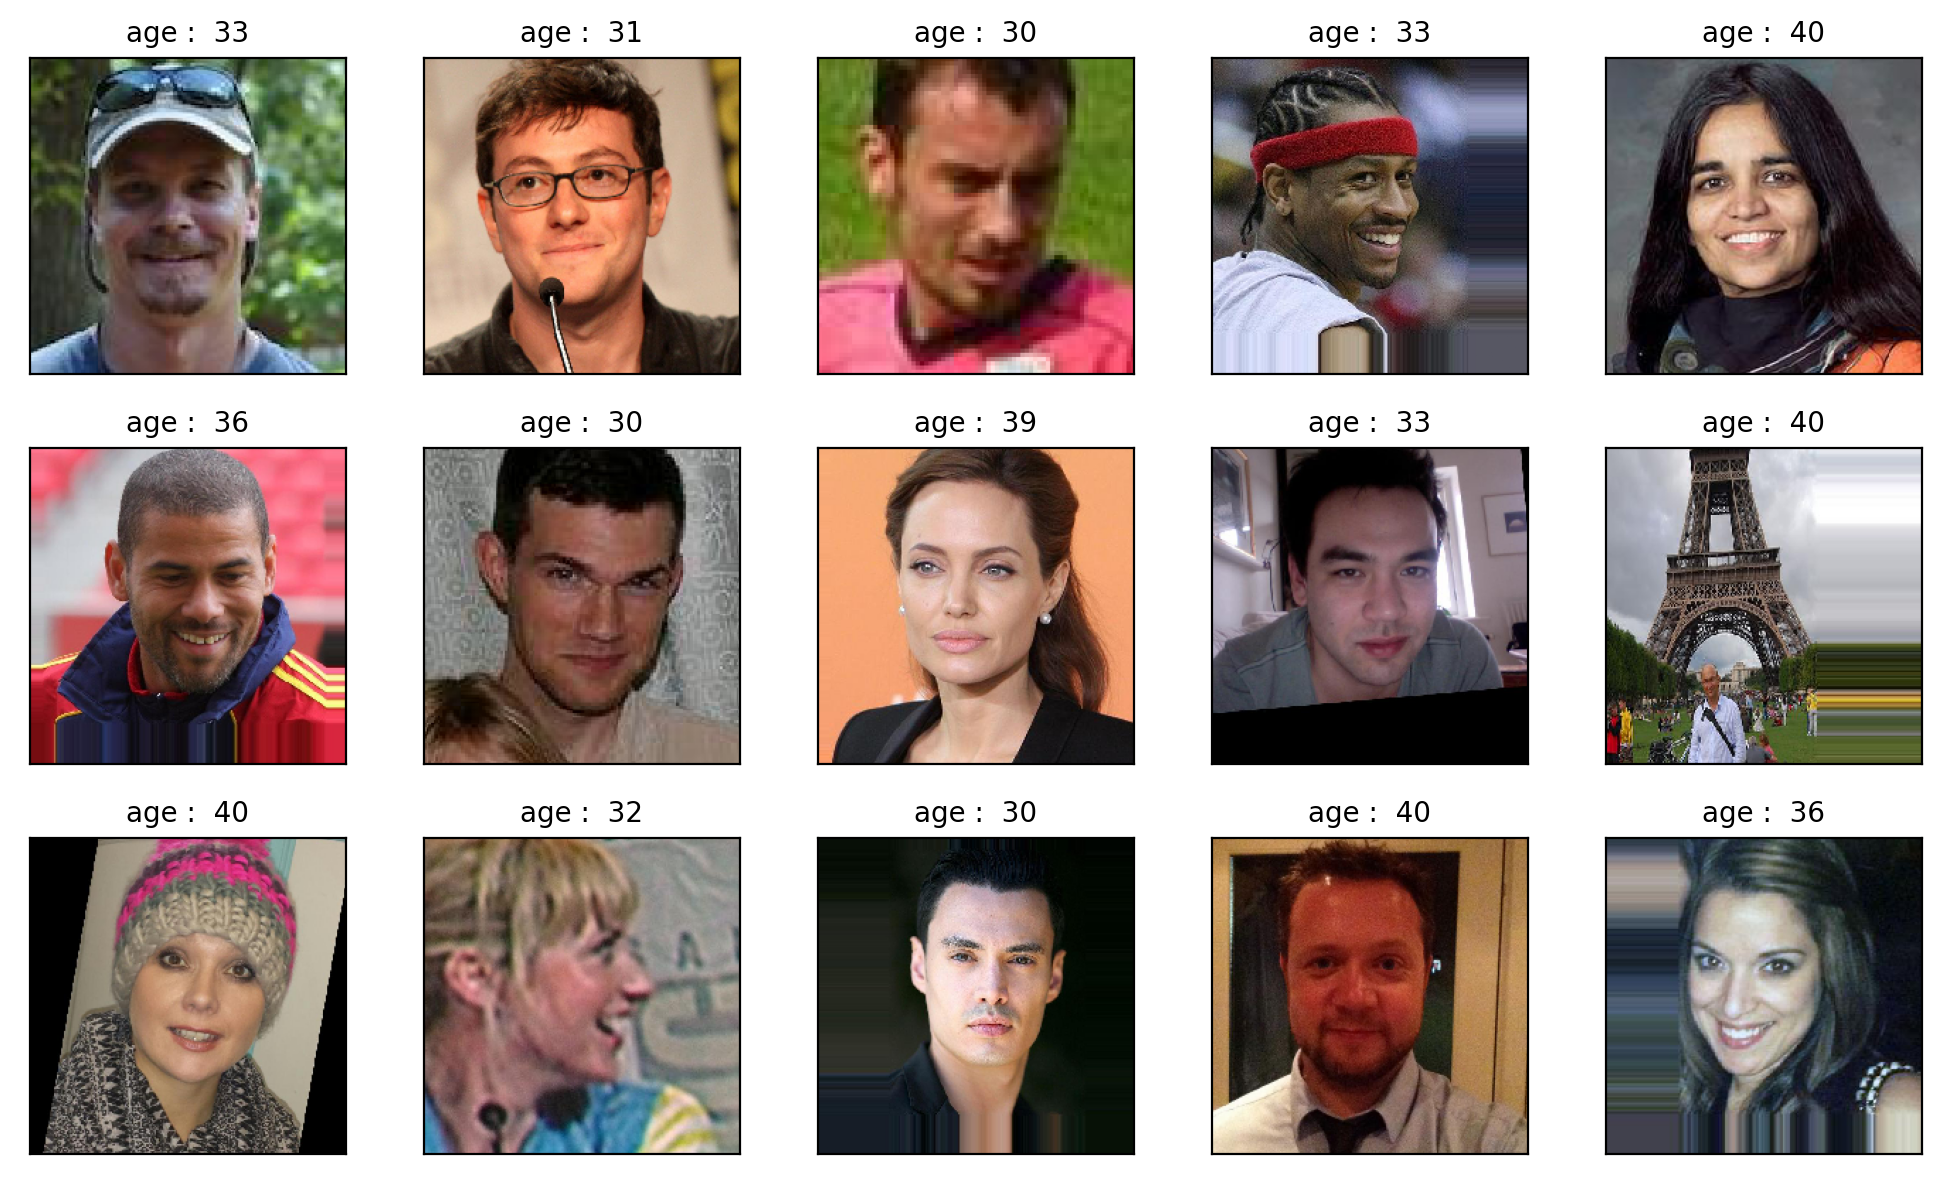

In [14]:
show_batch(next(gen_30_40))

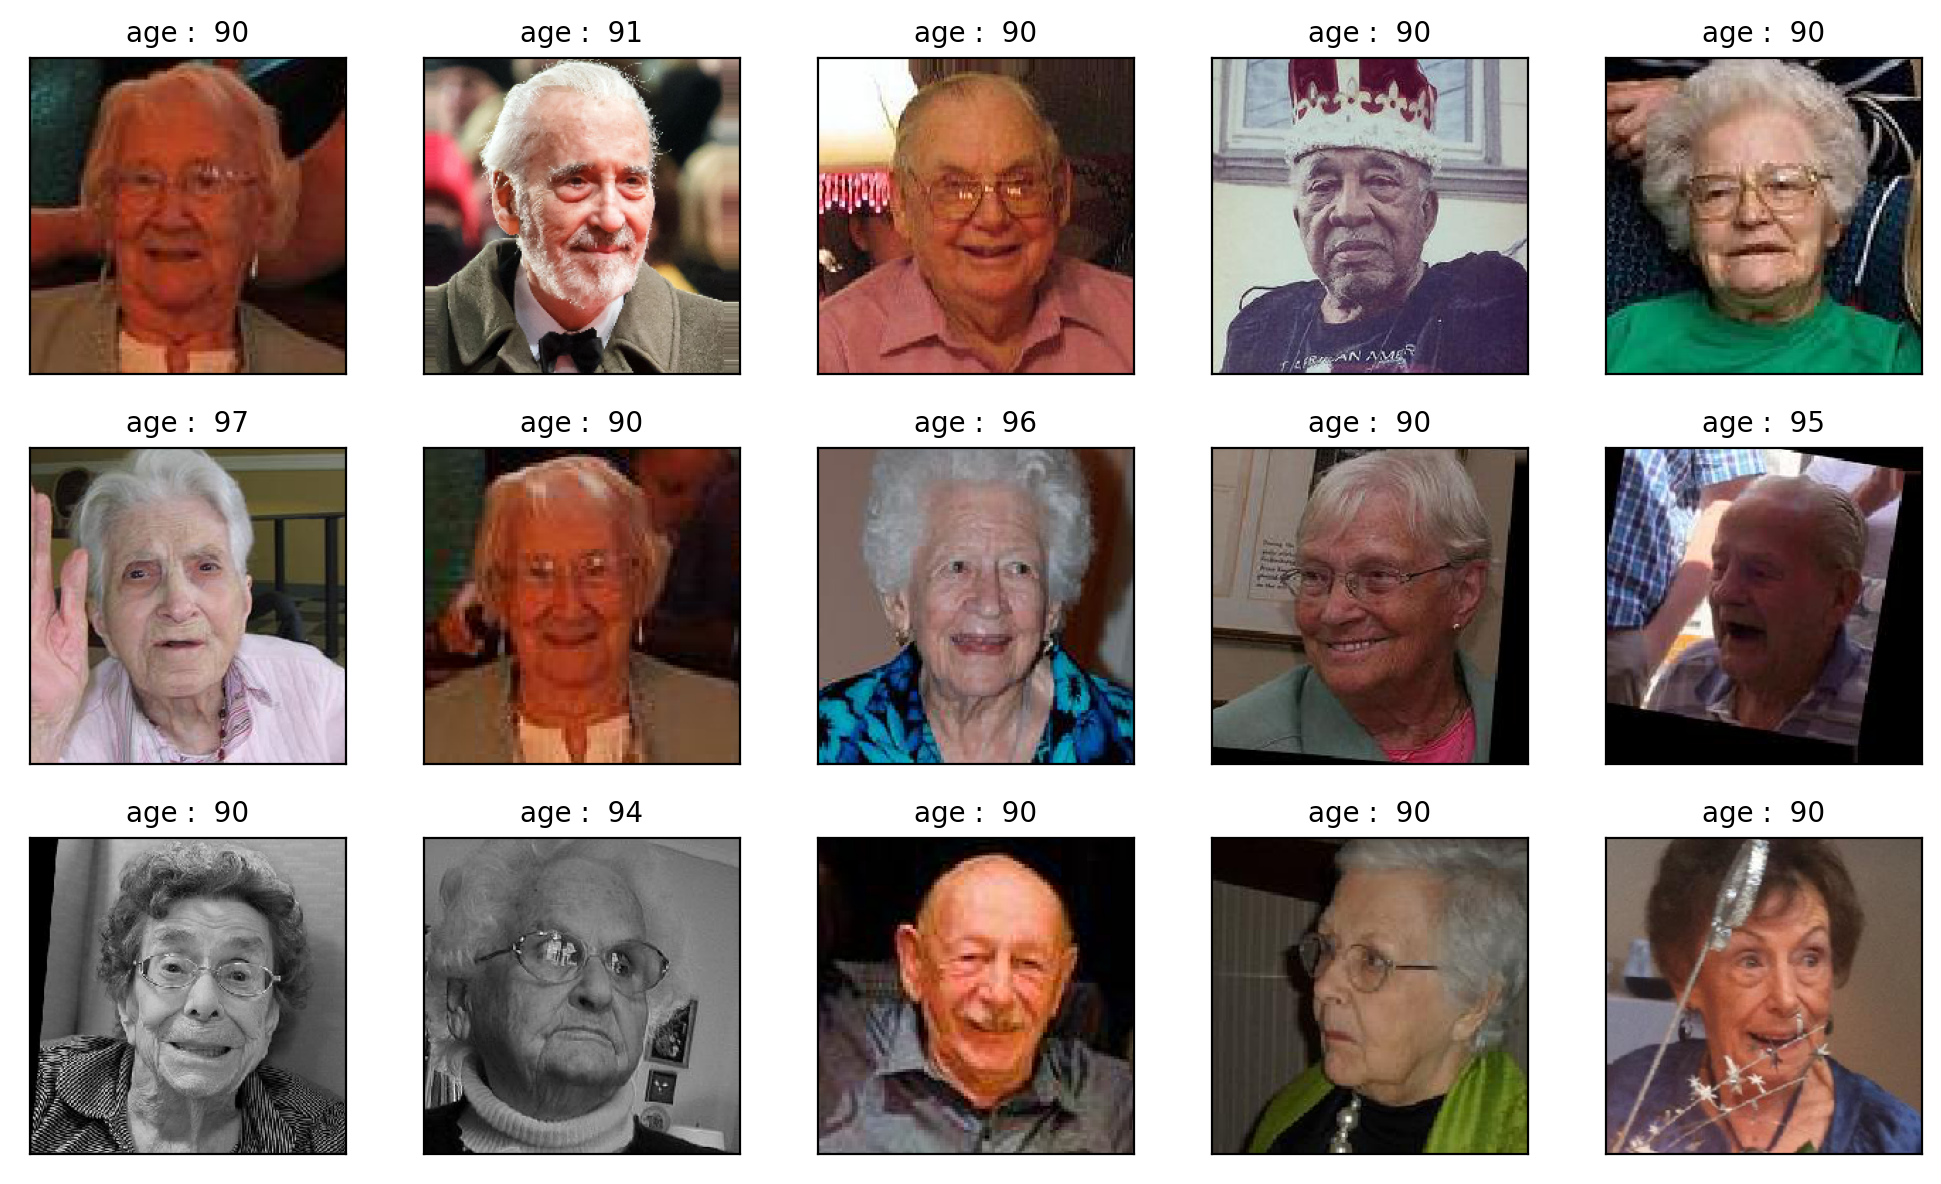

In [15]:
show_batch(next(gen_90_100 ))

### Temuan

Findings :
- ukuran foto semuanya sama yaitu 224x224,ini menyesuaikan dengan model yang di training sebelumnya di ImageNet
- Ukuran wajah dalam foto berbeda beda, mungkin diperlukan pengaturan pembesaran
- hampir semua orientasi foto sudah tepat, sehingga  hanya horizontal flip yang aplicable untuk dataset ini
- dataset foto berisi foto dengan bermacam kualitas, serta ada yang hitam putih dan berwarna


## Pemodelan 

Definisikan fungsi-fungsi yang diperlukan untuk melatih model Anda pada platform GPU dan buat satu skrip yang berisi semua fungsi tersebut beserta bagian inisialisasi.

Untuk mempermudah tugas ini, Anda dapat mendefinisikannya dalam *notebook* ini dan menjalankan kode siap pakai di bagian berikutnya untuk menyusun skrip secara otomatis.
Definisi di bawah ini juga akan diperiksa oleh *project reviewer* agar mereka dapat memahami cara Anda membangun model.

In [16]:
def load_train(path):
    
    """
    Kode ini memuat bagian training set dari file path
    """
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split = 0.25,
        horizontal_flip = True,
        rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path+ 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset = 'training',
        seed=12345) 


    return train_gen_flow

In [17]:
def load_test(path):
    
    """
    Kode ini memuat bagian validation set/test set dari file path
    """
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        validation_split = 0.25,
        rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path+ 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345) 

    return test_gen_flow

In [18]:
def create_model(input_shape):
    
    """
    Kode ini mendefinisikan model
    """
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(
        optimizer=Adam(lr=0.0005),
        loss='mse',
        metrics=['mae'],
    )
    

    return model

In [19]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Melatih model dengan parameter yang diberikan
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


## Siapkan Skrip untuk menjalankan platform GPU

Setelah Anda mendefinisikan fungsi-fungsi yang diperlukan, Anda dapat membuat skrip untuk platform GPU, mengunduhnya melalui menu "File|Open...", dan mengunggahnya nanti untuk dijalankan pada platform GPU. "

Catatan: Skrip Anda juga harus menyertakan bagian inisialisasi. Contohnya ditunjukkan di bawah ini.

In [20]:
# siapkan skrip untuk menjalankan platform GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Letakkan *output* dari platform GPU sebagai sel *Markdown* di sini.

- Train for 356 steps, validate for 475 steps
- Epoch 1/20
- 2023-05-24 01:32:25.240064: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
- 2023-05-24 01:32:25.542124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
- 356/356 - 100s - loss: 205.3543 - mae: 10.8580 - val_loss: 293.8880 - val_mae: 13.1587
- Epoch 2/20
- 356/356 - 71s - loss: 137.8671 - mae: 8.9815 - val_loss: 331.1504 - val_mae: 13.7374
- Epoch 3/20
- 356/356 - 81s - loss: 115.4603 - mae: 8.2083 - val_loss: 154.3865 - val_mae: 9.4655
- Epoch 4/20
- 356/356 - 65s - loss: 95.3885 - mae: 7.4516 - val_loss: 106.2604 - val_mae: 7.7461
- Epoch 5/20
- 356/356 - 65s - loss: 82.6511 - mae: 6.9396 - val_loss: 109.3842 - val_mae: 7.5304
- Epoch 6/20
- 356/356 - 65s - loss: 66.1661 - mae: 6.2463 - val_loss: 75.2854 - val_mae: 6.5399
- Epoch 7/20
- 356/356 - 65s - loss: 54.9643 - mae: 5.7155 - val_loss: 150.6231 - val_mae: 8.8396
- Epoch 8/20
- 356/356 - 69s - loss: 59.4599 - mae: 5.8790 - val_loss: 66.8546 - val_mae: 6.3873
- Epoch 9/20
- 356/356 - 66s - loss: 45.5533 - mae: 5.2108 - val_loss: 95.2594 - val_mae: 7.1479
- Epoch 10/20
- 356/356 - 65s - loss: 35.3230 - mae: 4.5943 - val_loss: 51.4547 - val_mae: 5.3702
- Epoch 11/20
- 356/356 - 65s - loss: 29.5504 - mae: 4.2045 - val_loss: 69.4736 - val_mae: 6.1871
- Epoch 12/20
- 356/356 - 66s - loss: 27.6998 - mae: 4.0386 - val_loss: 44.6581 - val_mae: 4.9944
- Epoch 13/20
- 356/356 - 80s - loss: 27.5143 - mae: 4.0372 - val_loss: 100.6153 - val_mae: 7.4637
- Epoch 14/20
- 356/356 - 65s - loss: 24.1581 - mae: 3.8040 - val_loss: 42.1905 - val_mae: 4.7670
- Epoch 15/20
- 356/356 - 80s - loss: 20.9975 - mae: 3.5562 - val_loss: 46.9989 - val_mae: 5.0221
- Epoch 16/20
- 356/356 - 65s - loss: 20.9103 - mae: 3.5246 - val_loss: 50.7813 - val_mae: 5.3075
- Epoch 17/20
- 356/356 - 65s - loss: 19.0787 - mae: 3.3511 - val_loss: 55.2156 - val_mae: 5.5859
- Epoch 18/20
- 356/356 - 66s - loss: 17.3828 - mae: 3.1974 - val_loss: 52.0616 - val_mae: 5.2680
- Epoch 19/20
- 356/356 - 82s - loss: 19.0006 - mae: 3.3295 - val_loss: 38.2631 - val_mae: 4.5615
- Epoch 20/20
- 356/356 - 82s - loss: 18.1844 - mae: 3.2716 - val_loss: 46.3972 - val_mae: 5.1117
- WARNING:tensorflow:sample_weight modes were coerced from
-  ...
-    to  
-  ['...']
- 475/475 - 40s - loss: 46.3972 - mae: 5.1117
- Test MAE: 5.1117

## Kesimpulan

Findings EDA :
- dataset gambar berisi foto dengan label berjumlah 7591
- rata-rata umur dari foto yang ada di dataset adalah 29 tahun
- ukuran dataset di dominasi oleh kelompok umur 15-40 tahun
- jumlah kelompok umur tua ( diatas 60 tahun ) hanya sedikit, kemungkinan model akan tidak akan ter-training dengan baik di kelompok umur ini sehingga kemungkinan kesalahanyang terjadi makin besar
- untuk analisa selanjutnya bisa berdasarkan beberapa kelompok umur, misalnya anak-anak, dewasa, dan tua
- Ukuran wajah dalam foto berbeda beda, mungkin diperlukan pengaturan pembesaran
- hampir semua orientasi foto sudah tepat, sehingga  hanya horizontal flip yang aplicable untuk dataset ini
- dataset foto berisi foto dengan bermacam kualitas, serta ada yang hitam putih dan berwarna

Analisa Pemodelan
- Model yang di aplikasikan adalah menggunakan arsitektur ResNet50, optimizer Adam dengan kecepatan 0.0005, activation relu sebanyak 20 epoch dan 16 batch size
- Model mampu memprediksi dengan dengan akurasi MAE sebesar 5.117

Kesimpulan
- Model mampu melakukan prediksi foto dari dataset yang ada dengan sangat baik

